## Tuning and Visualising Neighbourhood Clusters

In previous tutorials, we've shown how we can generate new labels for objects derived from spatially-resolved information, i.e., grouping cells into neighbourhoods using the `muspan.networks.cluster_neighbourhoods()` function. In spatial biology, this process is often more of an art than a science: the goal is to create meaningful, coarse-grained groups of cells that share similar patterns of label values (such as cell types) in a way that supports our scientific questions.

To achieve this, we need effective tools for visualising and tuning the clustering process. Conveniently, the `return_observation_matrix_and_labels` flag in `muspan.networks.cluster_neighbourhoods()` allows us to retrieve all the components required for this workflow. In this tutorial, we’ll show how to extract these components, use them for cluster optimisation, and visualise the resulting clusters in feature space using methods like UMAP or PCA.

Let’s begin by loading a synthetic dataset and performing neighbourhood clustering using categorical labels, as introduced in the first tutorial on neighbourhood clustering.

MuSpAn domain loaded successfully. Domain summary:
Domain name: Architecture
Number of objects: 5991
Collections: ['Cell centres']
Labels: ['Celltype'] 
Networks: [] 
Distance matrices: []


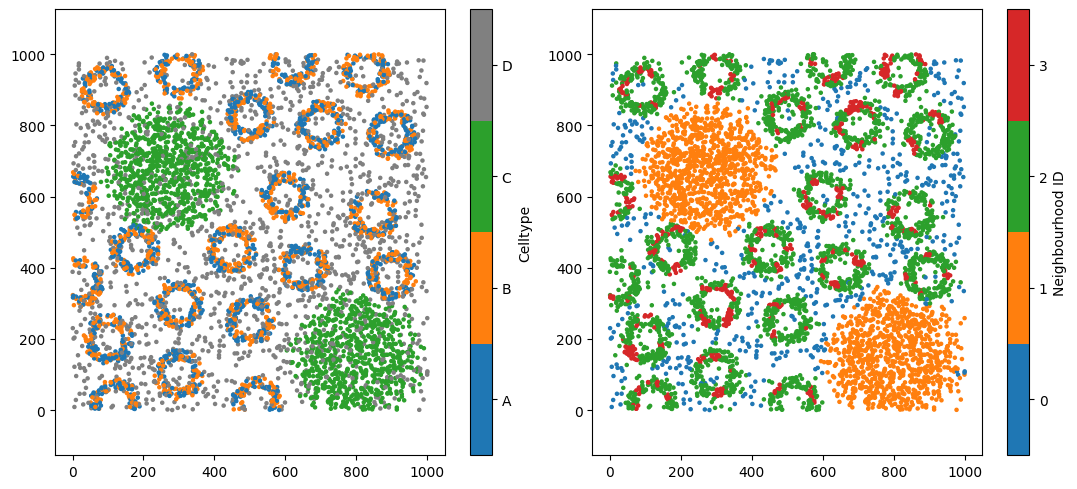

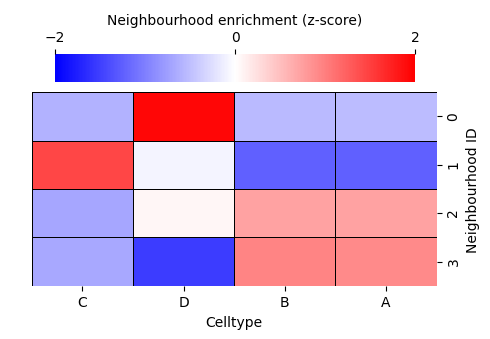

In [1]:
# Import necessary libraries
import muspan as ms
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load an example domain dataset
pc = ms.datasets.load_example_domain('Synthetic-Points-Architecture')

# Define network arguments for KNN
network_args_knn = dict(network_type='KNN', max_edge_distance=np.inf, min_edge_distance=0, number_of_nearest_neighbours=10)

# Perform neighbourhood clustering on the dataset using KNN and minibatchkmeans
enrichment_matrix, label_categories, cluster_categories = ms.networks.cluster_neighbourhoods(
    pc,  # The domain dataset
    label_name='Celltype',  # The label to use for clustering
    network_kwargs=network_args_knn,  # Network construction arguments
    k_hops=1,  # The number of hops to consider for the neighbourhood
    neighbourhood_label_name='Neighbourhood ID',  # Name for the neighbourhood label
    cluster_method='kmeans',  # Clustering method
    cluster_parameters={'n_clusters': 4},  # Parameters for the clustering method
    neighbourhood_enrichment_as='zscore' 
)

# Create a DataFrame from the neighbourhood enrichment matrix
df_ME_id = pd.DataFrame(data=enrichment_matrix, index=cluster_categories, columns=label_categories)
df_ME_id.index.name = 'Neighbourhood ID'
df_ME_id.columns.name = 'Celltype'



# Plotting everything out
fig,ax=plt.subplots(1,2,figsize=(11,5))
# Visualize the dataset, coloring by 'Celltype'
ms.visualise.visualise(pc, color_by='Celltype', ax=ax[0],marker_size=5)
ms.visualise.visualise(pc, color_by='Neighbourhood ID', ax=ax[1],marker_size=5)


# Visualize the neighbourhood enrichment matrix using a clustermap
sns.clustermap(
    df_ME_id,
    xticklabels=label_categories,
    yticklabels=cluster_categories,
    figsize=(5, 3.5),
    cmap='bwr',
    dendrogram_ratio=(.05, .3),
    col_cluster=False,
    row_cluster=False,
    square=True,
    linewidths=0.5,
    linecolor='black',
    cbar_kws=dict(use_gridspec=False, location="top", label='Neighbourhood enrichment (z-score)', ticks=[-2, 0, 2]),
    cbar_pos=(0.12, 0.75, 0.72, 0.08),
    vmin=-2,
    vmax=2,
    tree_kws={'linewidths': 0, 'color': 'white'}
)



Four neighbourhood clusters might not accurately represent your biology. But how do we choose the *right* number of clusters? This is a long-standing challenge in data science, and there is rarely a single “true” answer. Instead, we rely on the structure within our data to guide us.

To do this, we need to work with the *observation matrix*—the object that is actually being clustered inside the `muspan.networks.cluster_neighbourhoods()` function. Each row of this matrix corresponds to an object we want to assign a label to, while each column corresponds to a label-derived feature. In our example, the observation matrix contains 5,991 rows (one per cell) and four columns, representing the composition of cell types A, B, C, and D within each cell’s neighbourhood.

We can return both the observation matrix and the resulting cluster labels by setting `return_observation_matrix_and_labels=True`. This adds two additional outputs to the function call (see the documentation for `muspan.networks.cluster_neighbourhoods()` for details). We’ll return to the cluster-label output later in the tutorial.

In [2]:
# Perform neighbourhood clustering on the dataset using KNN and minibatchkmeans
enrichment_matrix, label_categories, cluster_categories,observation_matrix,object_cluster_labels = ms.networks.cluster_neighbourhoods(
    pc,  # The domain dataset
    label_name='Celltype',  # The label to use for clustering
    network_kwargs=network_args_knn,  # Network construction arguments
    k_hops=1,  # The number of hops to consider for the neighbourhood
    neighbourhood_label_name='Neighbourhood ID',  # Name for the neighbourhood label
    cluster_method='kmeans',  # Clustering method
    cluster_parameters={'n_clusters': 4},  # Parameters for the clustering method
    neighbourhood_enrichment_as='zscore' ,
    return_observation_matrix_and_labels=True # <-- New argument to return object cluster labels and observation matrix
)


Notice that we now have two additional outputs:
- observation_matrix – the feature matrix used to cluster the objects
- object_cluster_labels – an array containing the resulting cluster label for each object

Let’s verify that the observation matrix has the expected shape for this dataset: 5,991 objects and 4 categorical cell-type labels.

In [3]:
print('The shape of the observation matrix is:', observation_matrix.shape)

The shape of the observation matrix is: (5991, 4)


Now that we have the observation matrix, and we're using the clustering method k-means, we can use standard tools to guide our choice of *k* in k-means clustering—most commonly the **elbow method**, which evaluates how well different values of *k* fit the data.

In k-means, a common metric used for this is **inertia**. Inertia is the *within-cluster sum of squared distances*, and it measures how tightly the objects in each cluster group together. Lower inertia indicates that objects lie closer to their assigned cluster centres, suggesting a better clustering fit. However, inertia will always decrease as *k* increases, so the question becomes: *when does adding more clusters stop helping?*

This is where the **elbow plot** is useful. By plotting inertia against different values of *k*, we look for a point at which the rate of improvement sharply slows—the “elbow.” This point often represents a reasonable and interpretable choice for the number of clusters.

Let’s apply this approach to our synthetic dataset and explore how inertia behaves across several candidate values of *k*.

Text(0, 0.5, 'Inertia')

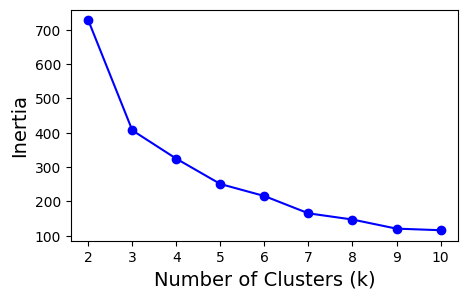

In [4]:
from sklearn.cluster import KMeans  

max_k_value=10
interia_clusters = []  # Initialize a list to store inertia values

for k in range(2, max_k_value+1):
    # Create a KMeans clusterer with the current number of clusters
    clusterer = KMeans(n_clusters=k, random_state=42)
    
    # Fit the model to the observation matrix and predict clusters
    clusterer.fit_predict(observation_matrix)
    
    # Append the inertia (sum of squared distances to closest cluster center) to the list
    interia_clusters.append(clusterer.inertia_)
    
fig,ax=plt.subplots(figsize=(5,3))  
ax.plot(range(2, max_k_value+1), interia_clusters, marker='o', linestyle='-', color='b')  # Plot inertia
ax.set_xlabel('Number of Clusters (k)', fontsize=14)  # Label for x-axis
ax.set_ylabel('Inertia', fontsize=14)  # Label for y-axis


It looks like choosing 3 clusters provides the best balance between clear separation of objects and keeping the number of groups minimal. Let’s now rerun our neighbourhood clustering using this updated choice of k.

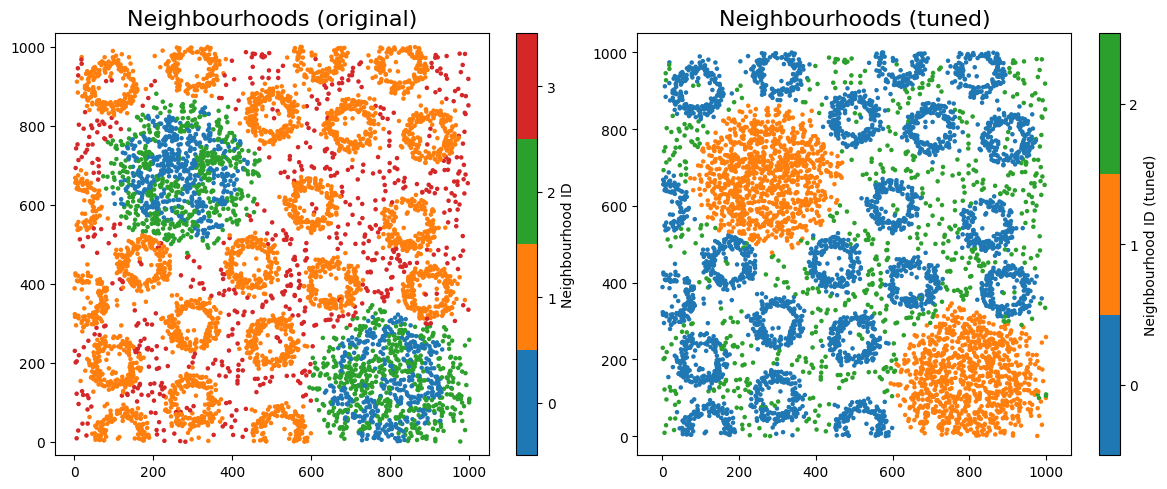

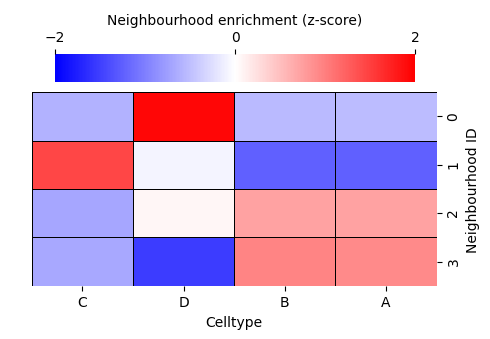

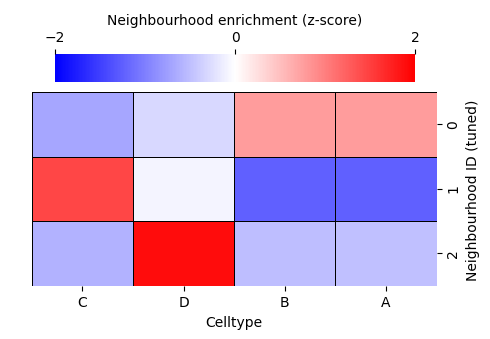

In [5]:
# Define network arguments for KNN
network_args_knn = dict(network_type='KNN', max_edge_distance=np.inf, min_edge_distance=0, number_of_nearest_neighbours=10)

# Perform neighbourhood clustering on the dataset using KNN and minibatchkmeans
enrichment_matrix_tuned, label_categories_tuned, cluster_categories_tuned,observation_matrix_tuned,object_cluster_labels_tuned = ms.networks.cluster_neighbourhoods(
    pc,  # The domain dataset
    label_name='Celltype',  
    network_kwargs=network_args_knn,  
    k_hops=1,  
    neighbourhood_label_name='Neighbourhood ID (tuned)',  
    cluster_method='kmeans',
    cluster_parameters={'n_clusters': 3},  # <-- Changed number of clusters to 3 following elbow analysis
    neighbourhood_enrichment_as='zscore',
    return_observation_matrix_and_labels=True
)

# Create a DataFrame from the neighbourhood enrichment matrix
df_ME_id_tuned = pd.DataFrame(data=enrichment_matrix_tuned, index=cluster_categories_tuned, columns=label_categories_tuned)
df_ME_id_tuned.index.name = 'Neighbourhood ID (tuned)'
df_ME_id_tuned.columns.name = 'Celltype'


# Plotting everything out in a grid
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
# Visualize the dataset, coloring by 'Celltype'
ms.visualise.visualise(pc, color_by='Neighbourhood ID', ax=ax[0], marker_size=5)
ax[0].set_title('Neighbourhoods (original)', fontsize=16)

ms.visualise.visualise(pc, color_by='Neighbourhood ID (tuned)', ax=ax[1], marker_size=5)
ax[1].set_title('Neighbourhoods (tuned)', fontsize=16)

# Visualize the neighbourhood enrichment matrix using a clustermap
enrichmap = sns.clustermap(
    df_ME_id,
    xticklabels=label_categories,
    yticklabels=cluster_categories,
    figsize=(5, 3.5),
    cmap='bwr',
    dendrogram_ratio=(.05, .3),
    col_cluster=False,
    row_cluster=False,
    square=True,
    linewidths=0.5,
    linecolor='black',
    cbar_kws=dict(use_gridspec=False, location="top", label='Neighbourhood enrichment (z-score)', ticks=[-2, 0, 2]),
    cbar_pos=(0.12, 0.75, 0.72, 0.08),
    vmin=-2,
    vmax=2,
    tree_kws={'linewidths': 0, 'color': 'white'}
)

# Visualize the neighbourhood enrichment matrix using a clustermap for tuned data
enrichmap_tuned = sns.clustermap(
    df_ME_id_tuned,
    xticklabels=label_categories_tuned,
    yticklabels=cluster_categories_tuned,
    figsize=(5, 3.5),
    cmap='bwr',
    dendrogram_ratio=(.05, .3),
    col_cluster=False,
    row_cluster=False,
    square=True,
    linewidths=0.5,
    linecolor='black',
    cbar_kws=dict(use_gridspec=False, location="top", label='Neighbourhood enrichment (z-score)', ticks=[-2, 0, 2]),
    cbar_pos=(0.12, 0.75, 0.72, 0.08),
    vmin=-2,
    vmax=2,
    tree_kws={'linewidths': 0, 'color': 'white'}
)



Let’s visualise the neighbourhoods using the `observation_matrix`, colouring each point by its resulting cluster label—similar to how phenotypic assignments are often displayed. In most real datasets, we typically have far more than four features (e.g. many cell-type categories), so dimension-reduction methods are essential for exploring and visualising neighbourhood structure.

In this example, we’ll use principal component analysis (PCA) to project the observation matrix into two dimensions. Because our features represent discrete proportions of categorical labels, the underlying structure is relatively simple and often well-captured by linear relationships. PCA is therefore a suitable choice here: it provides a fast, interpretable linear projection that preserves the major axes of variation in the data without imposing assumptions about more complex nonlinear structure.

Once projected into 2D, we can colour the points by their newly assigned cluster categories to examine how well the clusters separate in this feature space.


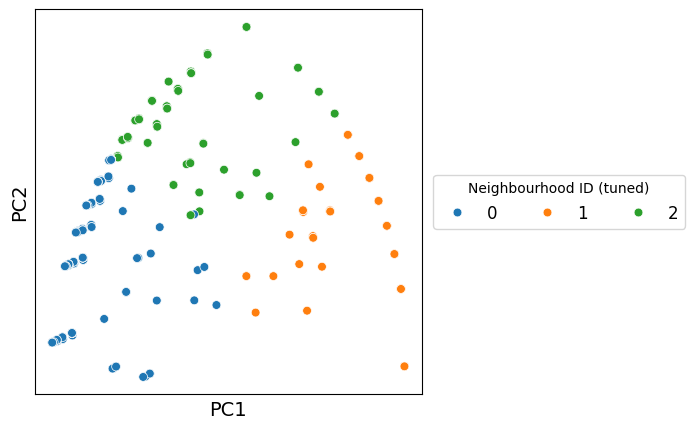

In [6]:
from sklearn.decomposition import PCA

# Perform PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(observation_matrix_tuned)

# Create a DataFrame for the PCA results
pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])
pca_df['Neighbourhood ID (tuned)'] = object_cluster_labels_tuned

# Plotting the PCA results
plt.figure(figsize=(5, 5))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Neighbourhood ID (tuned)', palette='tab10', s=40)
plt.xlabel('PC1', fontsize=14)
plt.ylabel('PC2', fontsize=14)
plt.xticks([])
plt.yticks([])
plt.legend(title='Neighbourhood ID (tuned)', fontsize=12, ncols=3,markerscale=1, loc='right', bbox_to_anchor=(1.7, 0.5))
plt.show()

Great — we can now generate a more intuitive view of how the clusters relate to one another. By projecting the observation matrix into a lower-dimensional space, we create a representation where clusters that share similar neighbourhood compositions appear closer together, while distinct clusters separate more clearly. This helps us build an intuitive mental model of the biological structure underlying the data, beyond what raw numeric features alone can convey.

Importantly, we’re not restricted to a specific dimension-reduction method. To demonstrate the same workflow with continuous labels, let’s switch to our Visium dataset and repeat the neighbourhood analysis from the previous tutorial. This time, instead of categorical cell-type proportions, we’ll visualise the space defined by topic compositions in each spot’s neighbourhood.

As before, we’ll return both the observation matrix and the cluster labels so we can explore and compare the structure revealed by our clustering.

MuSpAn domain loaded successfully. Domain summary:
Domain name: Visium-Colon-Adenocarcinoma
Number of objects: 6487
Collections: ['Spots']
Labels: ['Barcode', 'Spot cluster', 'Spot diameter', 'Topic 1', 'Topic 2', 'Topic 3', 'Topic 4', 'Topic 5', 'Topic 6', 'Topic 7', 'Topic 8', 'Topic 9', 'Topic 10', 'Topic 11', 'Topic 12', 'Topic 13', 'Topic 14', 'Topic 15', 'Topic 16'] 
Networks: [] 
Distance matrices: []


(<Figure size 1000x800 with 2 Axes>, <Axes: >)

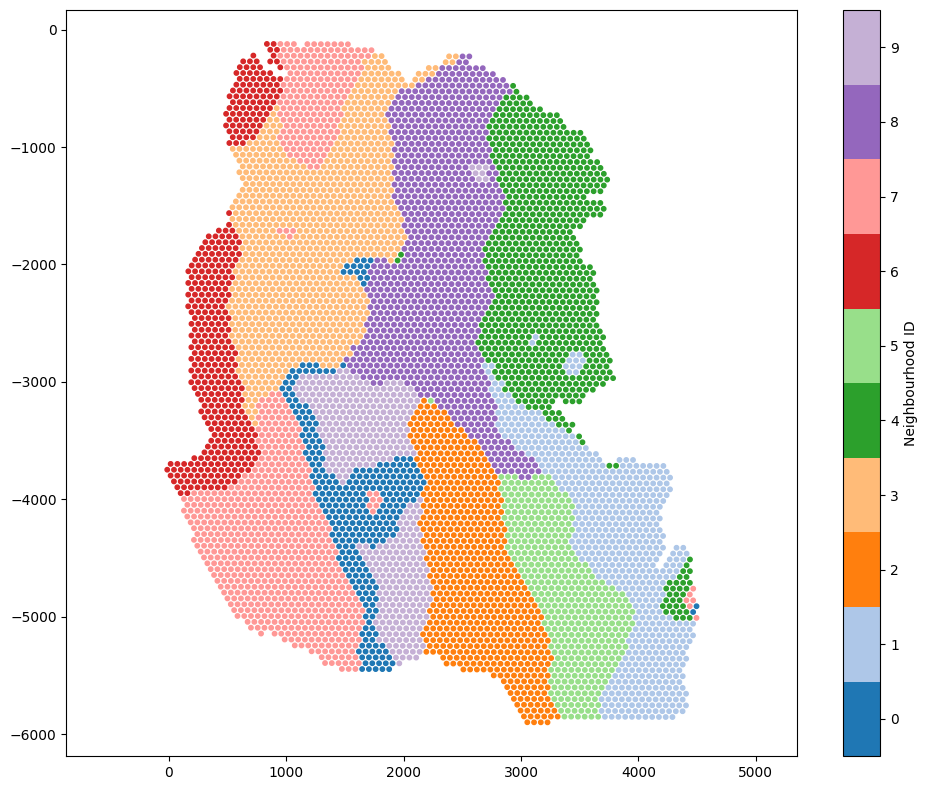

In [7]:
# Load the example domain dataset
example_domain = ms.datasets.load_example_domain('Visium-Colon-Adenocarcinoma')

# get a list of all numeric labels we want to use for neighbourhood clustering - these are the topic labels (continuous annotations)
numeric_labels = [f'Topic {i}' for i in range(1,17)]

# Perform cluster neighbourhood analysis
neighbourhood_enrichment_matrix,label_categories,cluster_categories,obs_matrix,cluster_labels=ms.networks.cluster_neighbourhoods(example_domain,
                                   label_name=numeric_labels,
                                   network_kwargs=dict(network_type='Delaunay',max_edge_distance=220),
                                   k_hops=3,
                                   transform_neighbourhood_composition='sqrt',
                                   neighbourhood_label_name='Neighbourhood ID',
                                   cluster_method='kmeans',
                                   cluster_parameters=dict(n_clusters=10),
                                   neighbourhood_enrichment_as='zscore',
                                   return_observation_matrix_and_labels=True)

ms.visualise.visualise(example_domain,color_by='Neighbourhood ID',marker_size=10)

Because these continuous labels may exhibit non-linear relationships, we can use UMAP to visualise the neighbourhood composition of each topic for each spot.

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


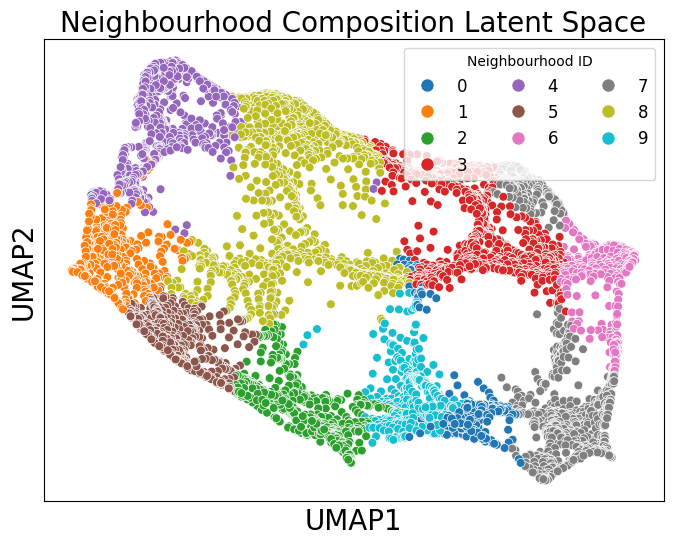

In [8]:
import umap

# Perform UMAP
umap_model = umap.UMAP(n_neighbors=400,n_components=2, random_state=42)
umap_result = umap_model.fit_transform(obs_matrix)

# Create a DataFrame for the UMAP results
umap_df = pd.DataFrame(data=umap_result, columns=['UMAP1', 'UMAP2'])
umap_df['Neighbourhood ID'] = cluster_labels

# Plotting the UMAP results
plt.figure(figsize=(8, 6))
sns.scatterplot(data=umap_df, x='UMAP1', y='UMAP2', hue='Neighbourhood ID', palette='tab10', s=40)
plt.xlabel('UMAP1', fontsize=20)
plt.ylabel('UMAP2', fontsize=20)
plt.legend(title='Neighbourhood ID',fontsize=12, loc='upper right', ncol=3, markerscale=1.5)  
plt.xticks([])
plt.yticks([])
plt.title('Neighbourhood Composition Latent Space', fontsize=20)
plt.show()

Each point in the embedding represents the topic composition of a spot in the Visium HD dataset. This allows us to visualise how neighbourhoods relate to one another in terms of similarity, while keeping in mind the usual caveats of non-linear dimensionality-reduction methods.

In this tutorial, we demonstrated how to export the relevant information from `muspan.networks.cluster_neighbourhoods()` in order to optimise clustering with external tools, and how to visualise the resulting cluster labels in neighbourhood space. Together, these features give users full control and flexibility when building a neighbourhood-analysis workflow for biological data. We encourage users to take advantage of this functionality whenever exploring neighbourhood structure.